In [14]:
#Transfer Learning Cifar10
import torch,torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torch.nn as nn
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=ToTensor())
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [33]:
from torchvision.transforms import Compose, Resize, Normalize

In [15]:
print(len(cifar_trainset))

50000


In [16]:
import torch
if torch.cuda.is_available():
    device=torch.device(type="cuda", index=0)
else:
    device=torch.device(type="cpu", index=0)   

In [17]:
batch_size=70
train_dl = DataLoader(cifar_trainset, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(cifar_testset, batch_size=batch_size, shuffle=True)

In [18]:
print(len(train_dl))
print(len(test_dl))

715
143


In [19]:
random_input=[]
for j,(img, labels) in enumerate(train_dl):
    print(j, img.shape)
    print(labels)
    random_input=img
    random_input2=img[2]
    break

0 torch.Size([70, 3, 32, 32])
tensor([7, 2, 2, 5, 1, 4, 7, 6, 0, 4, 2, 0, 0, 7, 7, 8, 8, 4, 0, 6, 8, 1, 1, 4,
        7, 8, 0, 2, 8, 9, 3, 2, 0, 7, 3, 8, 1, 6, 8, 6, 1, 2, 7, 7, 3, 9, 1, 4,
        5, 0, 2, 9, 1, 0, 3, 8, 0, 0, 0, 5, 6, 5, 7, 5, 2, 0, 9, 3, 6, 0])


In [21]:
random_input2.shape

torch.Size([3, 32, 32])

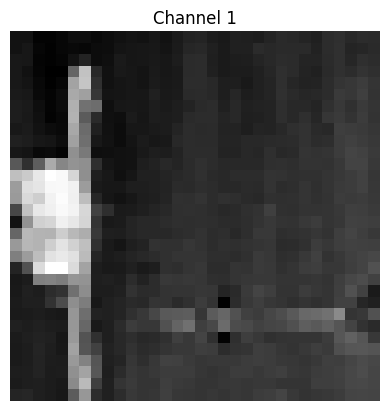

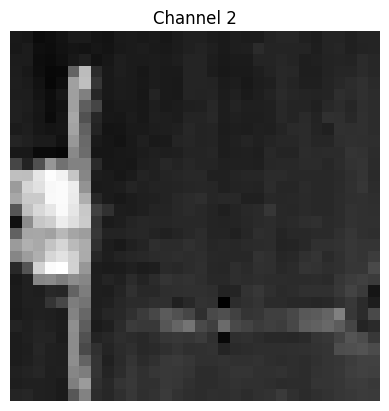

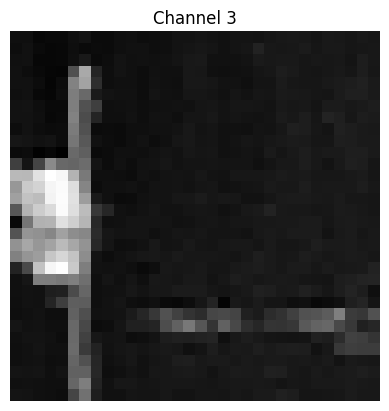

In [22]:
import matplotlib.pyplot as plt
for i in range(random_input2.shape[0]):
    plt.figure()
    plt.imshow(random_input2[i], cmap='gray')
    plt.title(f'Channel {i+1}')
    plt.axis('off')

plt.show()

In [27]:
import torch
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights,vgg16
class cifar_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.pretrainednet=mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)
        self.pretrainednet.classifier=nn.Sequential(
            nn.Linear(in_features=960, out_features=1280, 
                   bias=True),nn.Hardswish(), 
            nn.Dropout(p=0.2, inplace=True), 
            nn.Linear(in_features=1280, out_features=10, 
                      bias=True)
        )
    def forward(self, x):
        x=self.pretrainednet(x)
        return x
        

In [46]:
import torch
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights,vgg16
class cifar_model_resnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.pretrainednet=resnet50(weights=ResNet50_Weights.DEFAULT)
        self.classifier=nn.Sequential(
            nn.Linear(in_features=1000, out_features=1280, 
                   bias=True),nn.Hardswish(), 
            nn.Dropout(p=0.2, inplace=True), 
            nn.Linear(in_features=1280, out_features=10, 
                      bias=True)
        )
    def forward(self, x):
        x=self.pretrainednet(x)
        x=self.classifier(x)
        return x
        

In [47]:
model=cifar_model_resnet()
print(random_input.shape)
print(model(random_input).shape)

torch.Size([70, 3, 32, 32])
torch.Size([70, 10])


In [24]:
model=cifar_model()
print(random_input.shape)
print(model(random_input).shape)

torch.Size([70, 3, 32, 32])
torch.Size([70, 10])


In [37]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    track_loss=0
    num_correct=0
    transform=Compose([Resize((224,224), antialias=True), Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
    for i, (imgs, labels) in enumerate(dataloader):
        imgs=imgs
        imgs=transform(imgs)
        labels=labels
#         print("1")
        pred=model(imgs)
#         print(i)
        loss=loss_fn(pred, labels)
        track_loss+=loss.item()
        num_correct+=(torch.argmax(pred, dim=1)==labels).type(torch.float).sum().item()
#         print(num_correct)
        running_loss=round(track_loss/(i+(imgs.shape[0]/batch_size)),2)
        running_acc=round((num_correct/((i*batch_size+imgs.shape[0])))*100,2)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if i%100==0:
            print("Batch:", i+1, "/",len(dataloader), "Running Loss:",running_loss, "Running Accuracy:",running_acc)
            
    epoch_loss=running_loss
    epoch_acc=running_acc
    return round(epoch_loss,2), round(epoch_acc,2)

def eval_one_epoch(dataloader, model, loss_fn):
    track_loss=0
    num_correct=0
    for i, (imgs, labels) in enumerate(dataloader):
        pred=model(imgs)
        loss=loss_fn(pred, labels)
        track_loss+=loss.item()
        num_correct+=(torch.argmax(pred, dim=1)==labels).type(torch.float).sum().item()
#         print(num_correct)
        
    epoch_loss=track_loss/len(dataloader)
    epoch_acc=(num_correct/len(dataloader.dataset))*100
    return round(epoch_loss,2), round(epoch_acc,2)

In [28]:
model=cifar_model()
model=model

loss_fn=nn.CrossEntropyLoss()
lr=0.001
for param in model.pretrainednet.features.parameters():
    param.requires_grad=False
# optimizer=torch.optim.SGD(params=model.parameters(), lr=lr)
optimizer=torch.optim.Adam(params=model.parameters(), lr=lr)
epochs=50

for i in range(epochs):
    print("Epoch: ", (i+1))
    train_epoch_loss, train_epoch_acc=train_one_epoch(train_dl, model, loss_fn, optimizer)
    val_epoch_loss, val_epoch_acc=eval_one_epoch(test_dl, model, loss_fn)
    print("Training:", "Epoch Loss:", train_epoch_loss, "Epoch Accuracy:", train_epoch_acc)
    print("Validation:", "Epoch Loss:", val_epoch_loss, "Epoch Accuracy:", val_epoch_acc)
    print("--------------------------------------------------")

Epoch:  1
Training: Epoch Loss: 1.79 Epoch Accuracy: 36.52
Validation: Epoch Loss: 1.74 Epoch Accuracy: 37.65
--------------------------------------------------
Epoch:  2
Training: Epoch Loss: 1.7 Epoch Accuracy: 39.72
Validation: Epoch Loss: 1.71 Epoch Accuracy: 39.37
--------------------------------------------------
Epoch:  3
Training: Epoch Loss: 1.66 Epoch Accuracy: 41.27
Validation: Epoch Loss: 1.71 Epoch Accuracy: 39.57
--------------------------------------------------
Epoch:  4
Training: Epoch Loss: 1.63 Epoch Accuracy: 42.78
Validation: Epoch Loss: 1.73 Epoch Accuracy: 39.82
--------------------------------------------------
Epoch:  5
Training: Epoch Loss: 1.61 Epoch Accuracy: 43.53
Validation: Epoch Loss: 1.73 Epoch Accuracy: 39.14
--------------------------------------------------
Epoch:  6
Training: Epoch Loss: 1.58 Epoch Accuracy: 44.53
Validation: Epoch Loss: 1.74 Epoch Accuracy: 39.16
--------------------------------------------------
Epoch:  7
Training: Epoch Loss: 1.5

KeyboardInterrupt: 

In [30]:
#without transform
model=cifar_model()
model=model

loss_fn=nn.CrossEntropyLoss()
lr=0.001
for param in model.pretrainednet.features.parameters():
    param.requires_grad=False
# optimizer=torch.optim.SGD(params=model.parameters(), lr=lr)
optimizer=torch.optim.Adam(params=model.parameters(), lr=lr)
epochs=50

for i in range(epochs):
    print("Epoch: ", (i+1))
    train_epoch_loss, train_epoch_acc=train_one_epoch(train_dl, model, loss_fn, optimizer)
    val_epoch_loss, val_epoch_acc=eval_one_epoch(test_dl, model, loss_fn)
    print("Training:", "Epoch Loss:", train_epoch_loss, "Epoch Accuracy:", train_epoch_acc)
    print("Validation:", "Epoch Loss:", val_epoch_loss, "Epoch Accuracy:", val_epoch_acc)
    print("--------------------------------------------------")

Epoch:  1
Batch: 1 / 715 Running Loss: 2.32 Running Accuracy: 14.29
Batch: 101 / 715 Running Loss: 1.95 Running Accuracy: 31.39
Batch: 201 / 715 Running Loss: 1.88 Running Accuracy: 33.77
Batch: 301 / 715 Running Loss: 1.85 Running Accuracy: 34.6
Batch: 401 / 715 Running Loss: 1.83 Running Accuracy: 35.47
Batch: 501 / 715 Running Loss: 1.81 Running Accuracy: 35.82
Batch: 601 / 715 Running Loss: 1.8 Running Accuracy: 36.07
Batch: 701 / 715 Running Loss: 1.79 Running Accuracy: 36.45
Training: Epoch Loss: 1.79 Epoch Accuracy: 36.49
Validation: Epoch Loss: 1.74 Epoch Accuracy: 38.31
--------------------------------------------------
Epoch:  2
Batch: 1 / 715 Running Loss: 1.74 Running Accuracy: 37.14
Batch: 101 / 715 Running Loss: 1.69 Running Accuracy: 40.37
Batch: 201 / 715 Running Loss: 1.7 Running Accuracy: 40.04
Batch: 301 / 715 Running Loss: 1.7 Running Accuracy: 40.07
Batch: 401 / 715 Running Loss: 1.7 Running Accuracy: 39.95
Batch: 501 / 715 Running Loss: 1.7 Running Accuracy: 39.98

KeyboardInterrupt: 

In [38]:
#with transform
model=cifar_model()
model=model

loss_fn=nn.CrossEntropyLoss()
lr=0.001
for param in model.pretrainednet.features.parameters():
    param.requires_grad=False
# optimizer=torch.optim.SGD(params=model.parameters(), lr=lr)
optimizer=torch.optim.Adam(params=model.parameters(), lr=lr)
epochs=50

for i in range(epochs):
    print("Epoch: ", (i+1))
    train_epoch_loss, train_epoch_acc=train_one_epoch(train_dl, model, loss_fn, optimizer)
    val_epoch_loss, val_epoch_acc=eval_one_epoch(test_dl, model, loss_fn)
    print("Training:", "Epoch Loss:", train_epoch_loss, "Epoch Accuracy:", train_epoch_acc)
    print("Validation:", "Epoch Loss:", val_epoch_loss, "Epoch Accuracy:", val_epoch_acc)
    print("--------------------------------------------------")

Epoch:  1
Batch: 1 / 715 Running Loss: 2.31 Running Accuracy: 10.0
Batch: 101 / 715 Running Loss: 1.03 Running Accuracy: 64.67
Batch: 201 / 715 Running Loss: 0.91 Running Accuracy: 68.3
Batch: 301 / 715 Running Loss: 0.86 Running Accuracy: 70.06
Batch: 401 / 715 Running Loss: 0.83 Running Accuracy: 71.08
Batch: 501 / 715 Running Loss: 0.81 Running Accuracy: 71.76
Batch: 601 / 715 Running Loss: 0.79 Running Accuracy: 72.4
Batch: 701 / 715 Running Loss: 0.77 Running Accuracy: 72.96
Training: Epoch Loss: 0.77 Epoch Accuracy: 73.01
Validation: Epoch Loss: 6.52 Epoch Accuracy: 17.05
--------------------------------------------------
Epoch:  2
Batch: 1 / 715 Running Loss: 0.56 Running Accuracy: 78.57


KeyboardInterrupt: 

In [ ]:
#with transform
model=cifar_model_resnet()
model=model

loss_fn=nn.CrossEntropyLoss()
lr=0.001
model.pretrainednet.requires_grad_=False
# optimizer=torch.optim.SGD(params=model.parameters(), lr=lr)
optimizer=torch.optim.Adam(params=model.parameters(), lr=lr)
epochs=50

for i in range(epochs):
    print("Epoch: ", (i+1))
    train_epoch_loss, train_epoch_acc=train_one_epoch(train_dl, model, loss_fn, optimizer)
    val_epoch_loss, val_epoch_acc=eval_one_epoch(test_dl, model, loss_fn)
    print("Training:", "Epoch Loss:", train_epoch_loss, "Epoch Accuracy:", train_epoch_acc)
    print("Validation:", "Epoch Loss:", val_epoch_loss, "Epoch Accuracy:", val_epoch_acc)
    print("--------------------------------------------------")

Epoch:  1
Batch: 1 / 715 Running Loss: 2.29 Running Accuracy: 8.57
Batch: 101 / 715 Running Loss: 0.81 Running Accuracy: 73.58
